# Somatic Validation

Notebook that demonstrates the somatic validation example.

In [1]:
from pathlib import Path
import pickle

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import evaluator
import model

In [2]:
%matplotlib inline
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)

We first need to extract features to be used in the somatic validation.

The directory L5TPC already contains the results of extracted features. For simplicity, we are going to use those results in this notebook.

To replicate the feature extraction results, please refer to the `extract_features.py` script or the `feature-extraction.ipnb` notebook.

In [3]:
script_dir = Path(".")

In [4]:
protocols_path = script_dir / "L5TPC" / "protocols.json"
features_path = script_dir / "L5TPC" / "features.json"

We will also need the model parameters from the optimisation step.

In [5]:
opt_model_params_path = (
    Path("..") / "optimisation" / "opt_module" / "config" / "params" / "pyr.json"
)

In [6]:
opt_model_params_path

PosixPath('../optimisation/opt_module/config/params/pyr.json')

In [7]:
script_dir.parent.parent

PosixPath('.')

Before beginning, we need to rescale the protocol amplitudes.

TODO: scientific motivation needed here. 

Maria mentioned that during the optimisation something gets scaled, we need to remove that factor. Reference needed.

In [8]:
# corrected_protocols_path = script_dir / "protocols_corrected.json"
# write_corrected_protocols(protocols_path, corrected_protocols_path)
# corrected_protocols_path = str(corrected_protocols_path)

Loading the bluepyopt hall-of-fame models and the morphology used in the optimisation.

In [9]:
opt_pickle_path = (
    Path("..")
    / "optimisation"
    / "opt_module"
    / "checkpoints"
    / "run.a6e707a"
    / "cADpyr_L5TPC_1.pkl"
)

with open(opt_pickle_path, "rb") as f:
    opt_pickle = pickle.load(f, encoding="latin1")

nevals = opt_pickle["logbook"].select("nevals")
opt_pickle = {
    "nevals": np.cumsum(nevals),
    "logbook": opt_pickle["logbook"],
    "hof": opt_pickle["halloffame"],
}

morphology_path = str(
    Path("..") / "optimisation" / "opt_module" / "morphologies" / "C060114A5.asc"
)

### Running the protocols

In [10]:
fitness_protocols = evaluator.define_protocols(protocols_path)

evaluator = evaluator.create(
    morphology_path, opt_model_params_path, features_path, protocols_path
)

cell = model.create(morphology_path, opt_model_params_path)
cell_params = [param.name for param in cell.params.values() if not param.frozen]


responses = evaluator.run_protocols(
    protocols=fitness_protocols.values(),
    param_values=dict(zip(cell_params, opt_pickle["hof"][0])),
)

../optimisation/opt_module/morphologies/C060114A5.asc


--No graphics will be displayed.


### Voltage responses

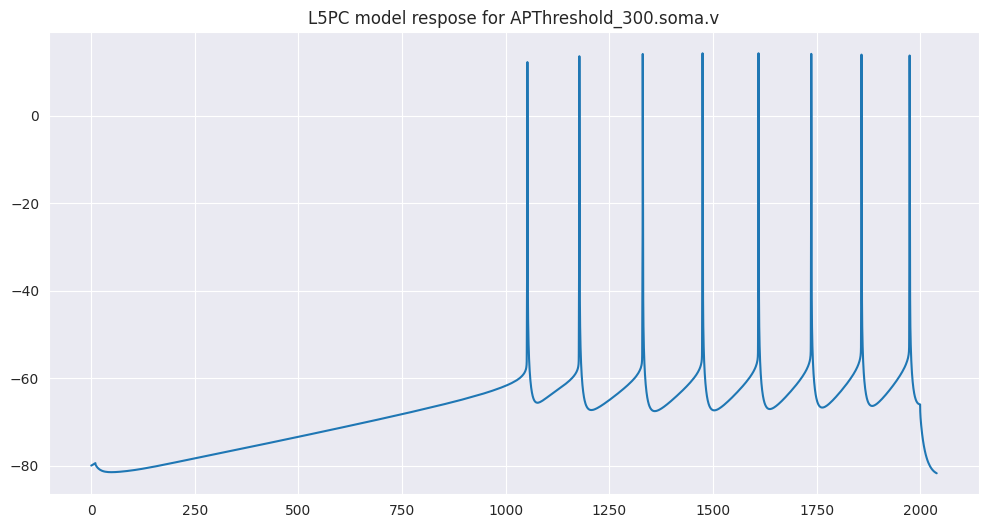

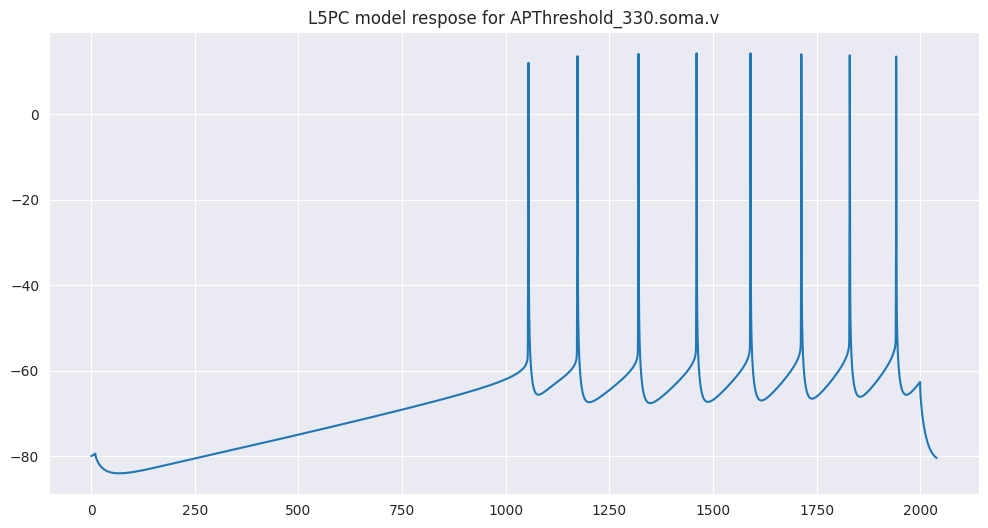

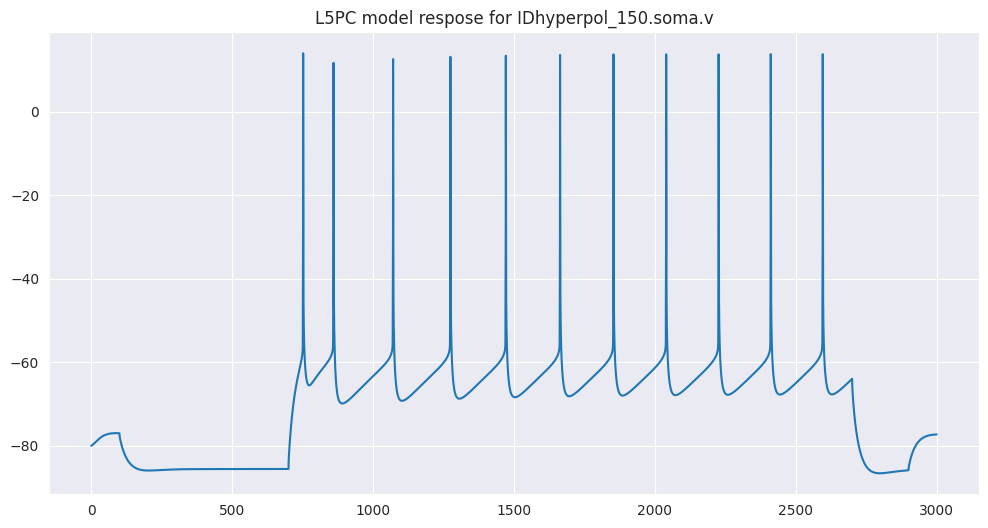

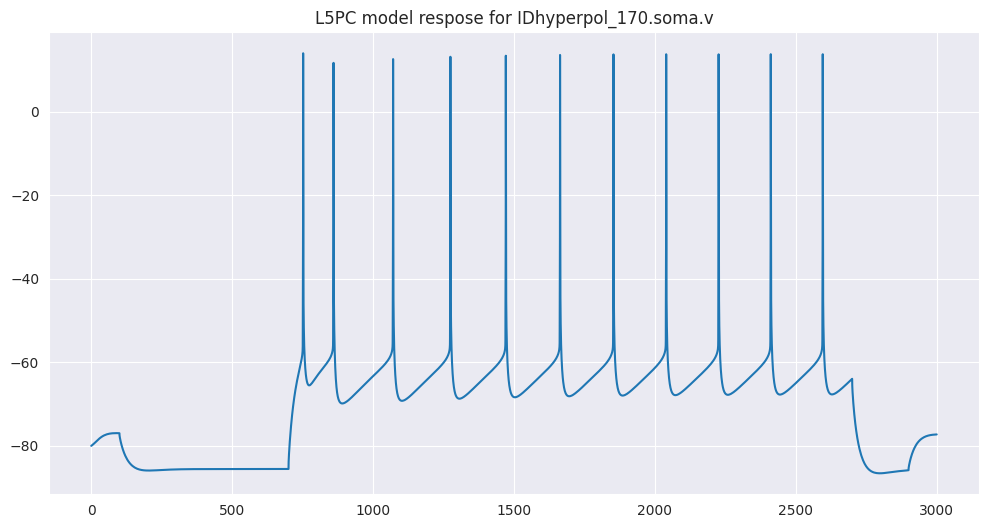

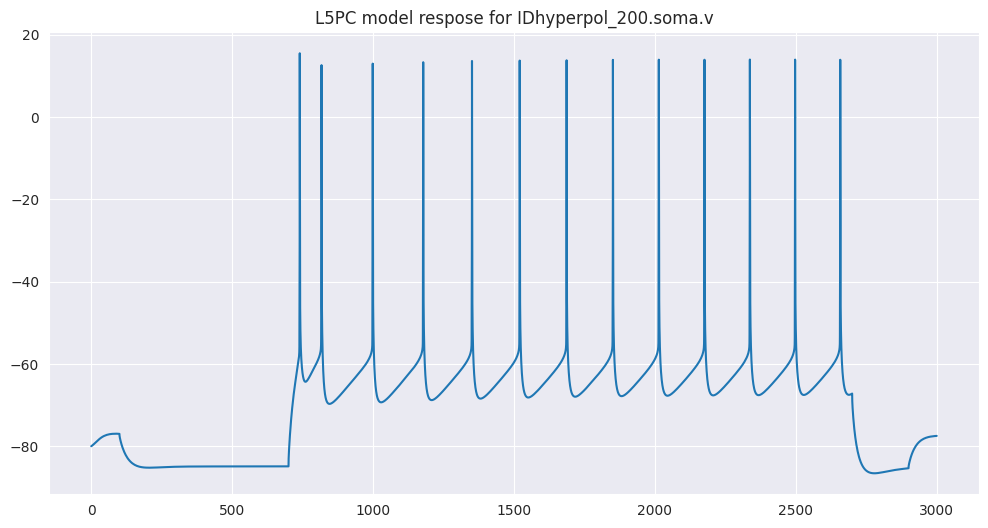

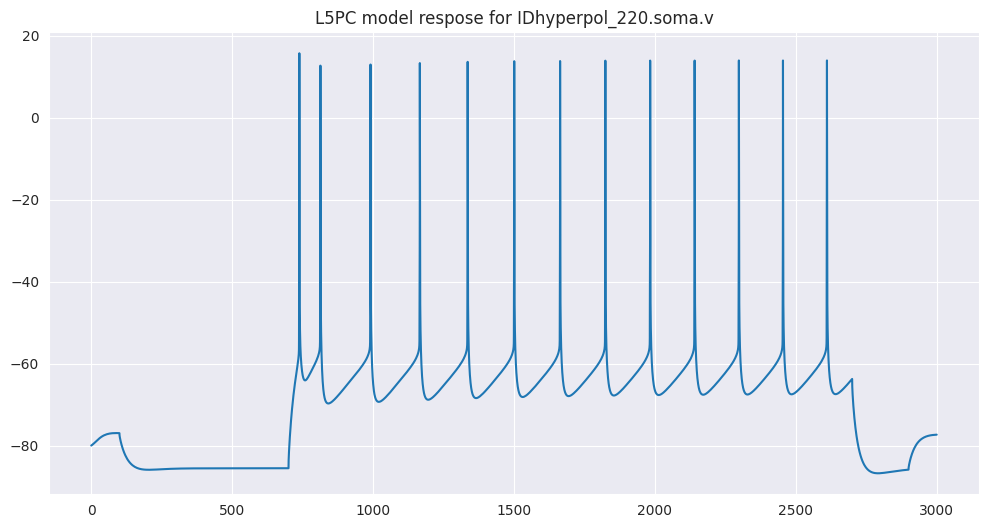

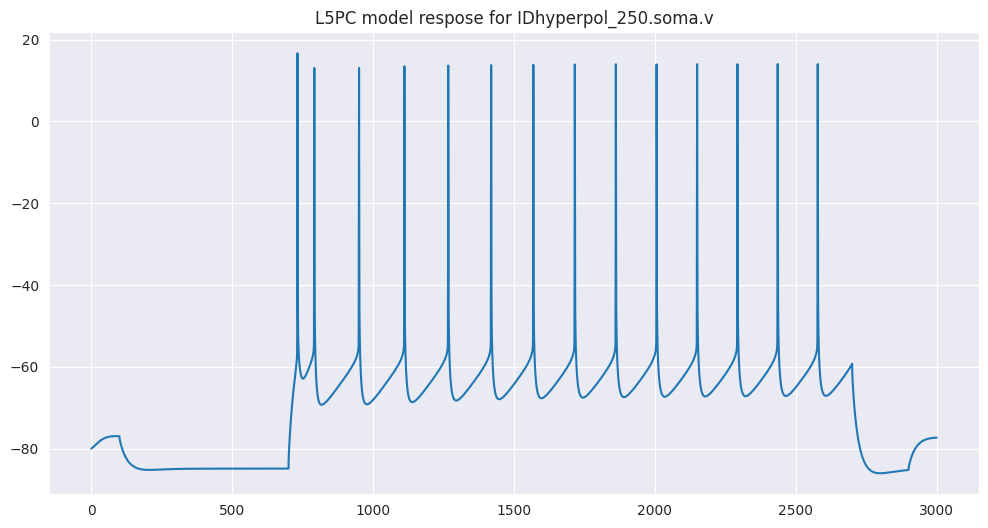

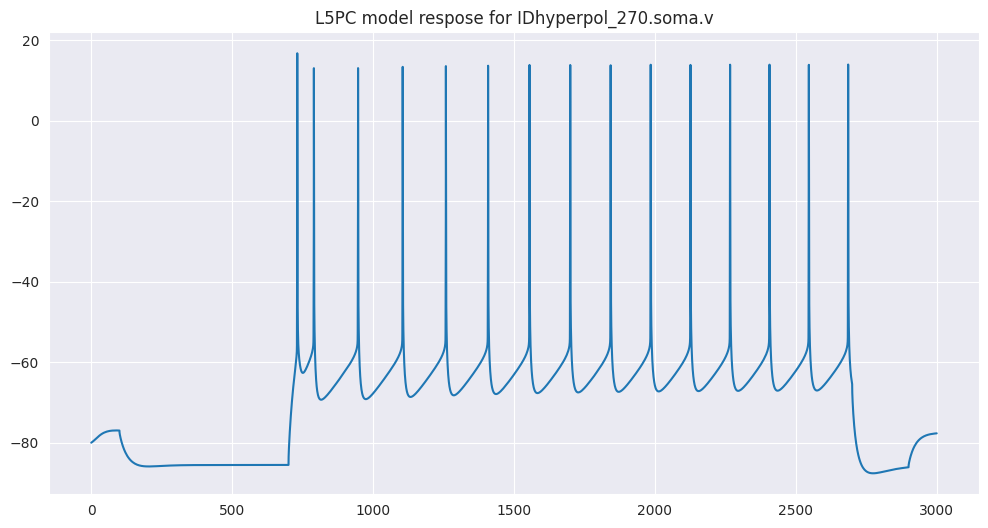

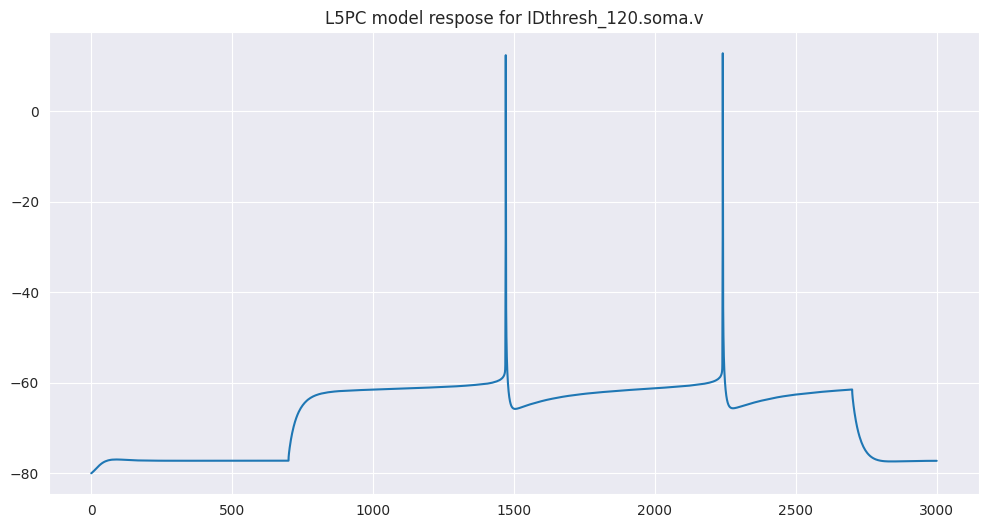

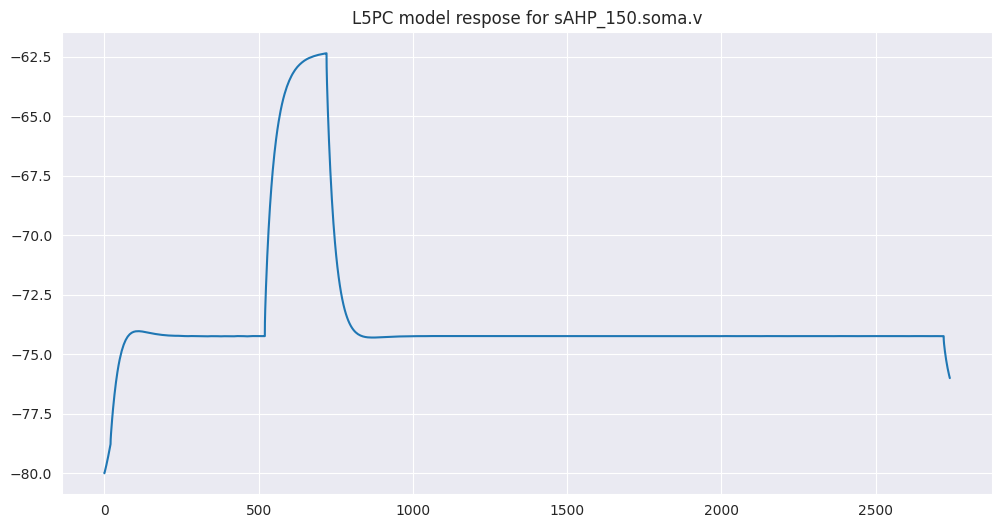

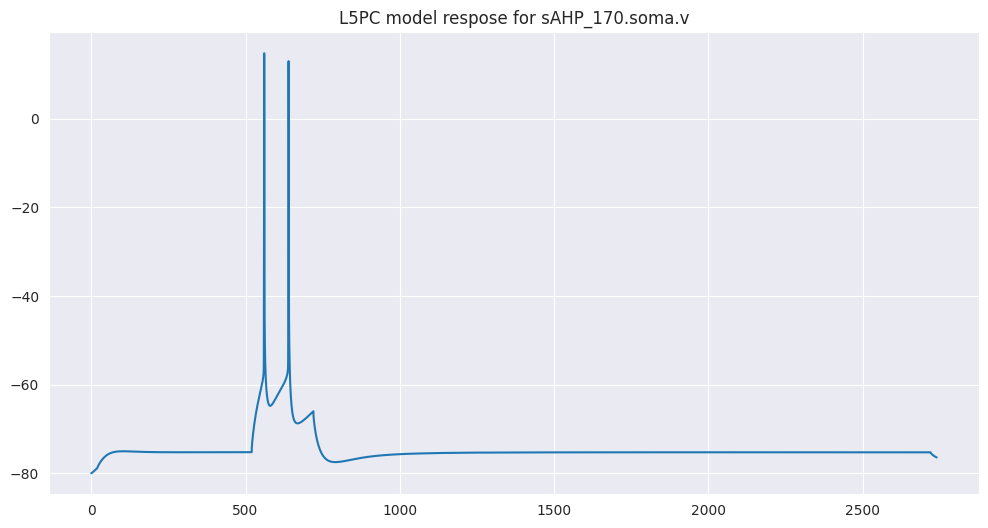

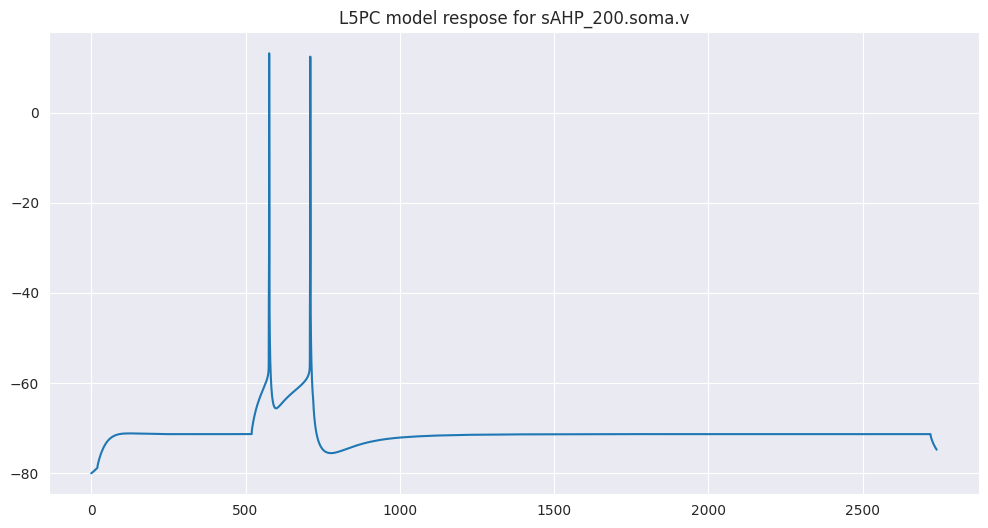

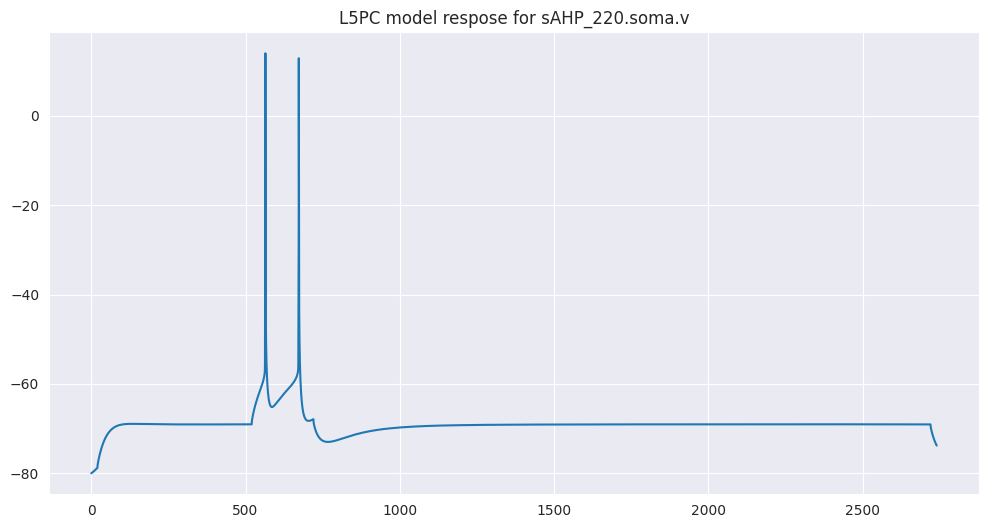

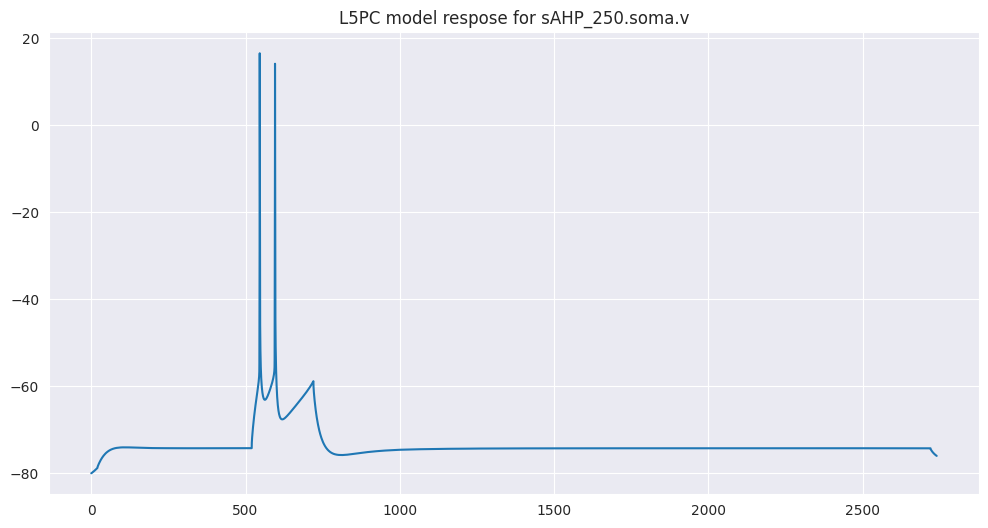

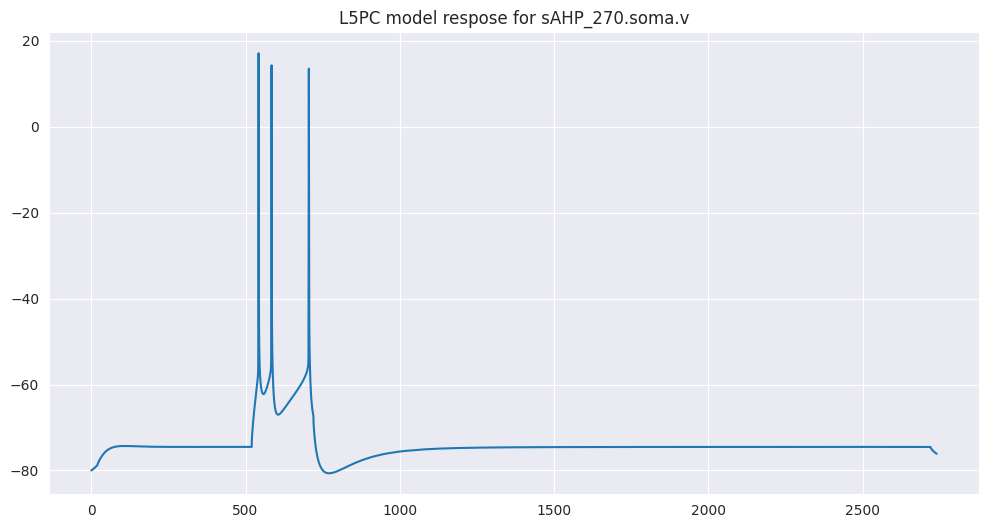

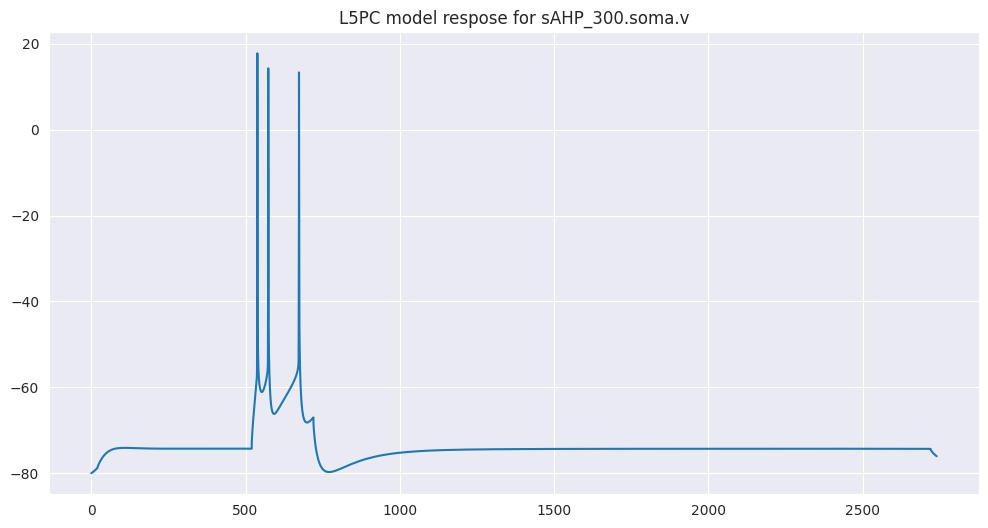

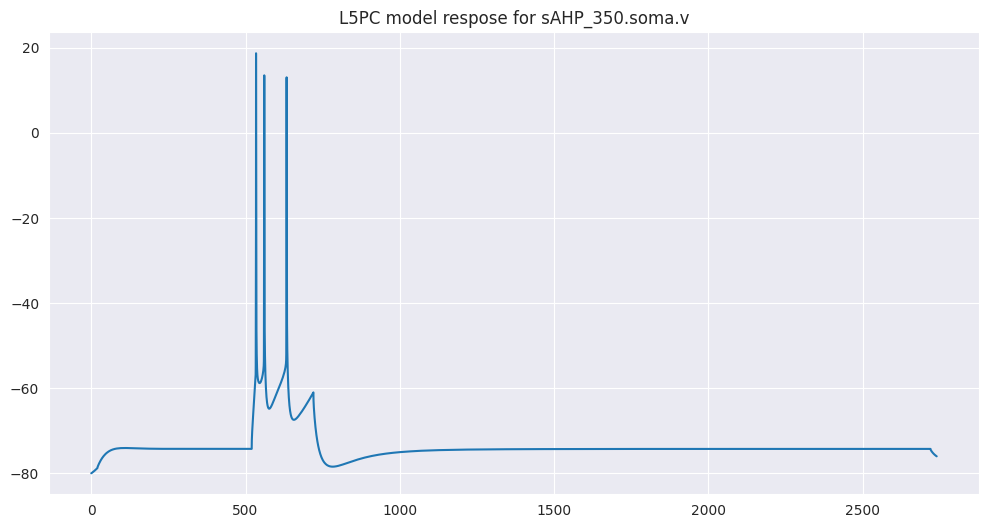

In [11]:
for index, (protocol_name, response) in enumerate(sorted(responses.items())):
    f=plt.figure()
    plt.plot(response['time'], response['voltage'], c="C0")
    plt.title('L5PC model respose for ' + protocol_name)
    plt.show()

In [12]:
objectives = evaluator.fitness_calculator.calculate_scores(responses)

In [13]:
def plot_objectives(objectives): 
    
    # Names for all the stimuli   
    stim_name = ['IDhyperpol_150','IDhyperpol_200','sAHP_200','sAHP_300','APThreshold_300' ]
    
    # Sort objectives
    obj_keys = [[key for key in objectives.keys() if key.split(".")[0] == stim] for stim in stim_name]
    #print((obj_keys))
    obj_keys = [item for sublist in obj_keys for item in sublist][::-1] 
    #print(len(obj_keys))

    obj_val = []
    for key in obj_keys:
        obj_val.append(objectives[key])
    #print(obj_val)
 
    ytick_pos = [x + 0.5 for x in range(len(obj_keys))]


    fig, ax = plt.subplots(figsize = (7,20), facecolor = 'white')
  
    ax.barh(ytick_pos,
              obj_val,
              height=0.5,
              align='center',
              color='blue',
              alpha=0.5)
    
    #obj_keys = [CellEvalSetup.tools.rename_feat(name) for name in obj_keys]     
        
    ax.set_yticks(ytick_pos)
    ax.set_yticklabels(obj_keys, size='medium')
    ax.set_ylim(-0.5, len(obj_keys) + 0.5)
    ax.set_xlim([0,10])
      
    ax.set_xlabel("Distance from exp. mean (# STD)")
    ax.set_ylabel("Feature name")
    ax.xaxis.grid(True)
    fig.tight_layout()

# plot_objectives(objectives)
#plt.savefig("validation1.pdf", dpi=150, bbox_inches='tight')



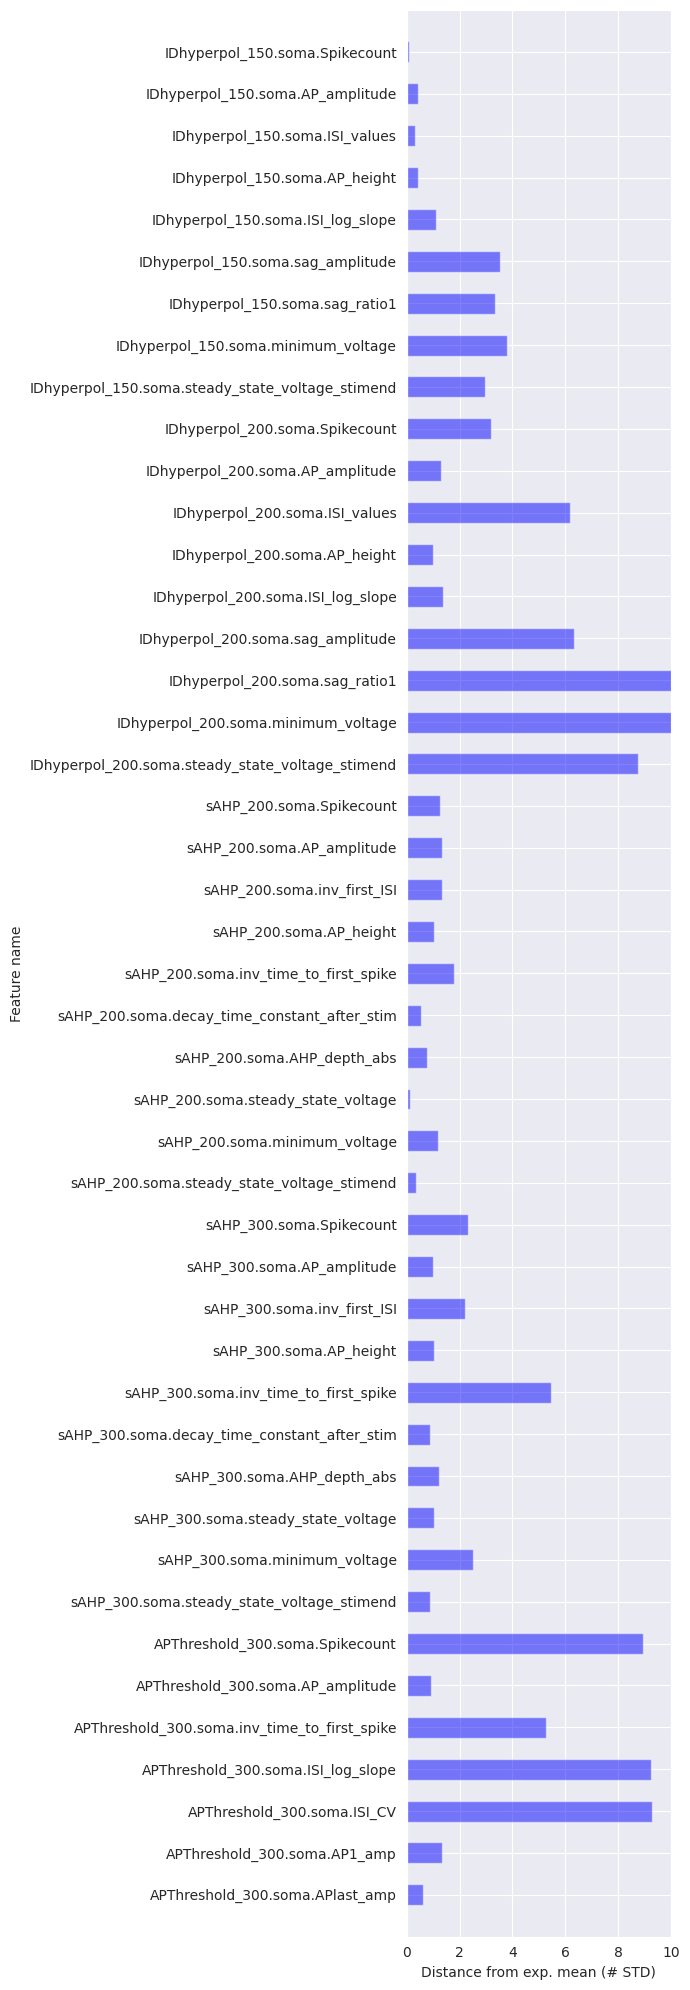

In [14]:
plot_objectives(objectives)